In [1]:
# importing required library to perform feature selection
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [10]:
from sklearn.preprocessing import StandardScaler

# importing the dataset
input_file = "chowdary.csv"
df = pd.read_csv(input_file)

# seperating the independent and dependent variables
X = df.iloc[:, 3:]
Y = df.iloc[:, 1]

# splitting the dataset into training and testing set
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=3)

scaler = StandardScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)

# Convert back to DataFrame
X_train_normalized_df = pd.DataFrame(X_train_normalized, columns=X_train.columns)
X_test_normalized_df = pd.DataFrame(X_test_normalized, columns=X_test.columns)

In [11]:
# summarizing the dataset
# number of 'B' and 'C' in training and testing set
print("The number of 'B' and 'C' in training set: ", Y_train.value_counts())
print("The number of 'B' and 'C' in testing set: ", Y_test.value_counts())
print("The shape of the training set is: ", X_train_normalized_df.shape)
print("The shape of the testing set is: ", X_test_normalized_df.shape)


The number of 'B' and 'C' in training set:  tumour
B    52
C    31
Name: count, dtype: int64
The number of 'B' and 'C' in testing set:  tumour
C    11
B    10
Name: count, dtype: int64
The shape of the training set is:  (83, 181)
The shape of the testing set is:  (21, 181)


In [12]:
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression

estimator = LogisticRegression(penalty = 'l2', max_iter=500)
cv = StratifiedKFold(n_splits=5)
rfecv = RFECV(estimator, step=1, cv=cv, scoring="accuracy")
# Define the parameter grid
param_grid = {
    'step': [1, 5, 10],
    'cv': [StratifiedKFold(n_splits=2), StratifiedKFold(n_splits=5), StratifiedKFold(n_splits=10)]
}

# Create the grid search object
grid_search = GridSearchCV(rfecv, param_grid, scoring='accuracy')

# Fit the grid search to the data
grid_search.fit(X_train_normalized_df, Y_train)

# Print the best parameters
print("Best parameters: ", grid_search.best_params_)

Best parameters:  {'cv': StratifiedKFold(n_splits=2, random_state=None, shuffle=False), 'step': 1}


In [13]:
# getting optimal number of features using RFECV
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
import seaborn as sns

# initializing the estimator model
estimator = LogisticRegression(penalty = 'l2',max_iter=500)

# setting up the RFECV with the estimator and cross-validation strategy
cv = StratifiedKFold(n_splits=2)
rfecv = RFECV(estimator, step=1, cv=cv, scoring='accuracy')

# fitting the data to the model
rfecv.fit(X_train_normalized_df, Y_train)

# getting the optimal number of features
optimal_n_features = rfecv.n_features_
print("Optimal number of features : %d" % optimal_n_features)

# naming of the features selected
selected_features = X_train_normalized_df.columns[rfecv.support_]
print("Selected features : %s" % selected_features)

# getting the cross-validated scores for each number of features
cv_scores = rfecv.cv_results_['mean_test_score']
# cv_scores = [score for i, score in enumerate(rfecv.cv_results_['mean_test_score']) if i in rfecv.get_support(indices=True)]


# getting the number of features for each iteration
n_features = list(range(1, len(cv_scores) + 1))


Optimal number of features : 5
Selected features : Index(['X202831_at', 'X204351_at', 'X204653_at', 'X209016_s_at',
       'X209604_s_at'],
      dtype='object')


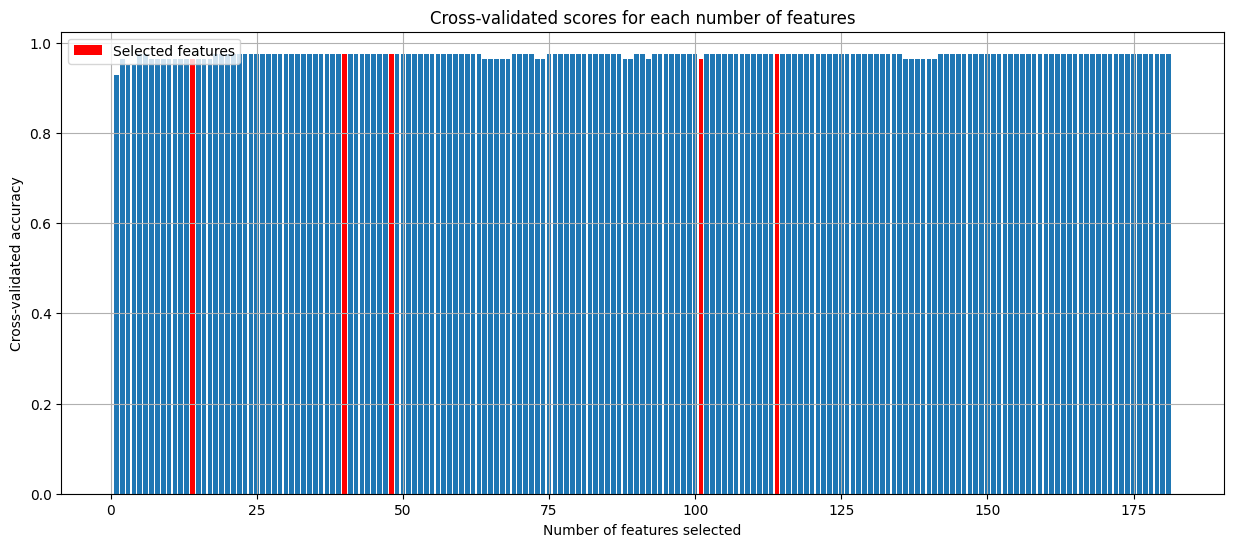

In [14]:
# plotting the accuracy vs number of features
plt.figure(figsize=(15, 6))
plt.bar(n_features, cv_scores)

# Highlight the selected features in red
selected_feature_indices = [list(X_train_normalized_df.columns).index(f) for f in selected_features]
selected_cv_scores = cv_scores[selected_feature_indices]
plt.bar(np.array(selected_feature_indices) + 1, selected_cv_scores, color='red', label='Selected features')

plt.xlabel("Number of features selected")
plt.ylabel("Cross-validated accuracy")
plt.title("Cross-validated scores for each number of features")

plt.legend()
plt.grid()
plt.show()

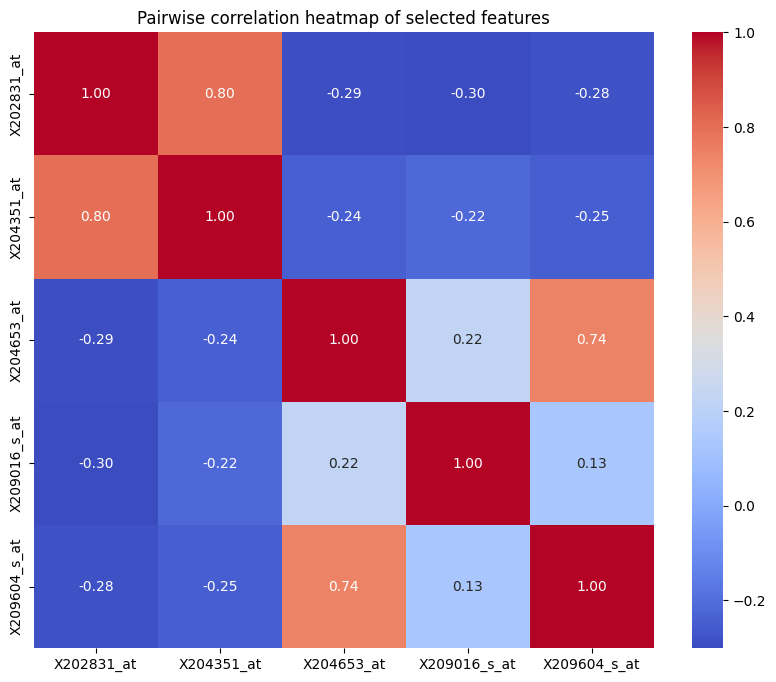

In [15]:
# plotting the heatmap of correlation matrix
# creating a dataframe with selected features
selected_data = X_train_normalized_df[selected_features]

# getting the correlation matrix
corr_matrix = selected_data.corr()

# plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Pairwise correlation heatmap of selected features")
plt.show()

In [7]:
# selected features, 'X202859_x_at', 'X203951_at', 'X205044_at', 'X205941_s_at', 'X209604_s_at', 'X213435_at', 'X217148_x_at'
# Create a contingency table for 'feature1' and 'feature2'
from scipy.stats import ttest_ind

# Perform an independent t-test between two groups
# group1 = X_train.loc[Y_train == 'B', 'X202859_x_at']
# group2 = X_train.loc[Y_train == 'C', 'X203951_at']
# t_stat, p_value = ttest_ind(group1, group2)

# # Print the t-statistic and p-value
# print("t-statistic:", t_stat)
# print("p-value:", p_value)

# plot_conditional_prob('X202859_x_at', 'X203951_at')

# Loop through all pairs of features and compute conditional probabilities
# for i, feature1 in enumerate(selected_features):
#     for j, feature2 in enumerate(selected_features):
#         if i != j:
#             plot_conditional_prob(feature1, feature2)

t-statistic: -2.554242212399358
p-value: 0.0125153858117985


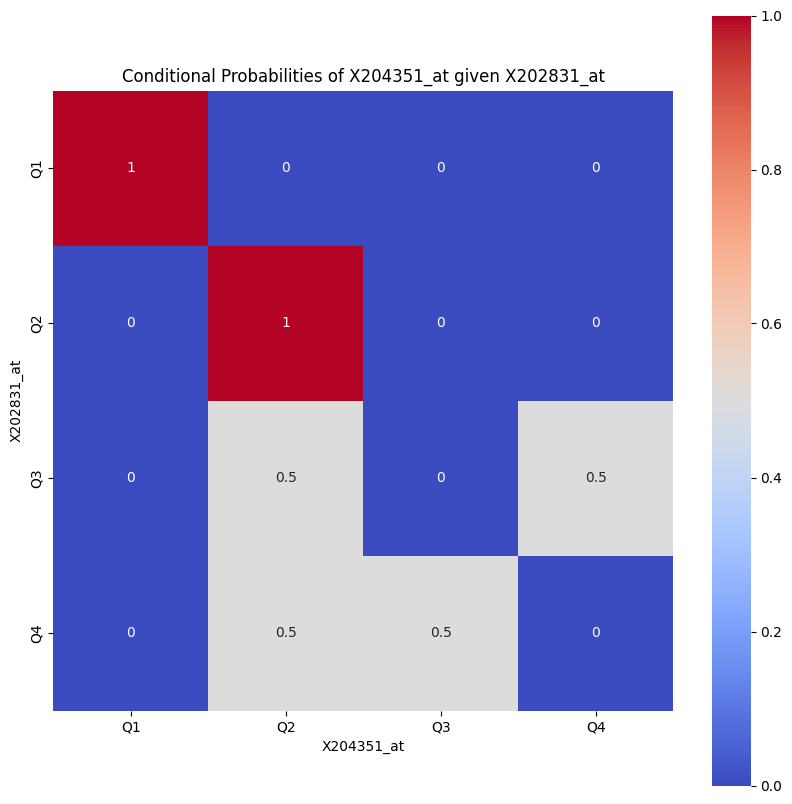

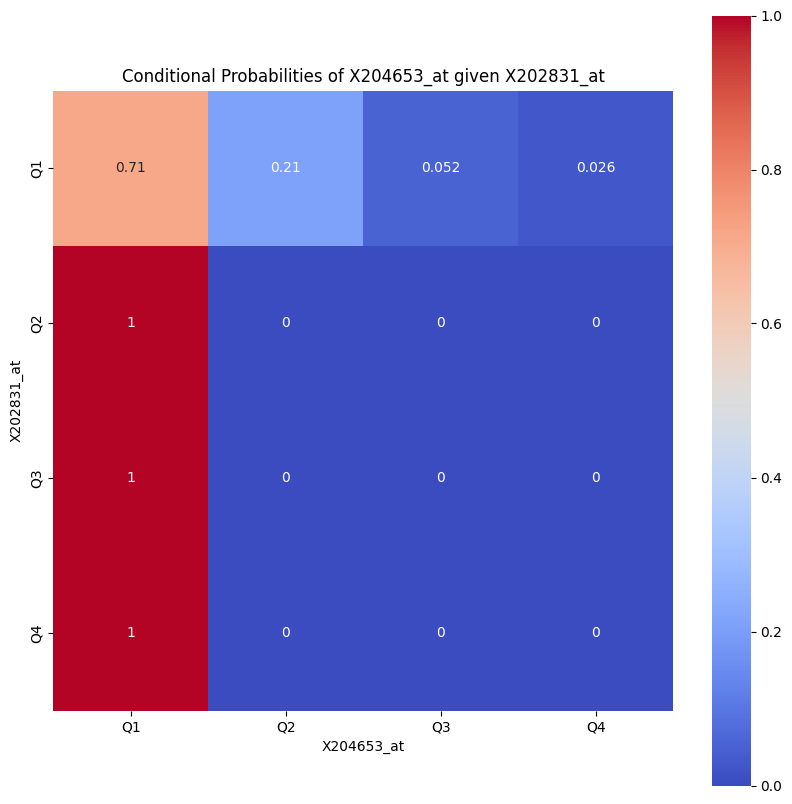

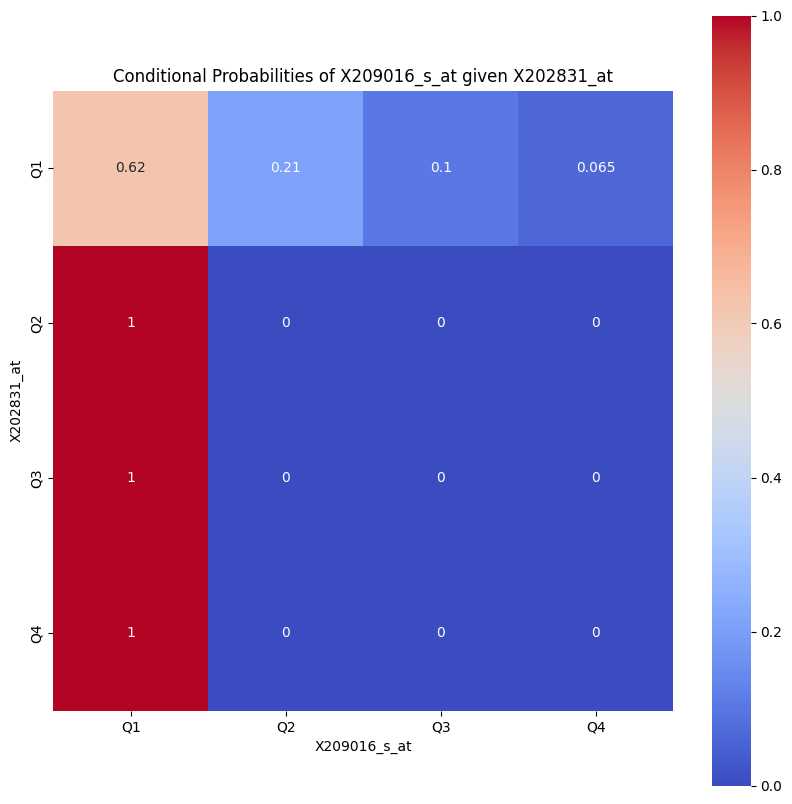

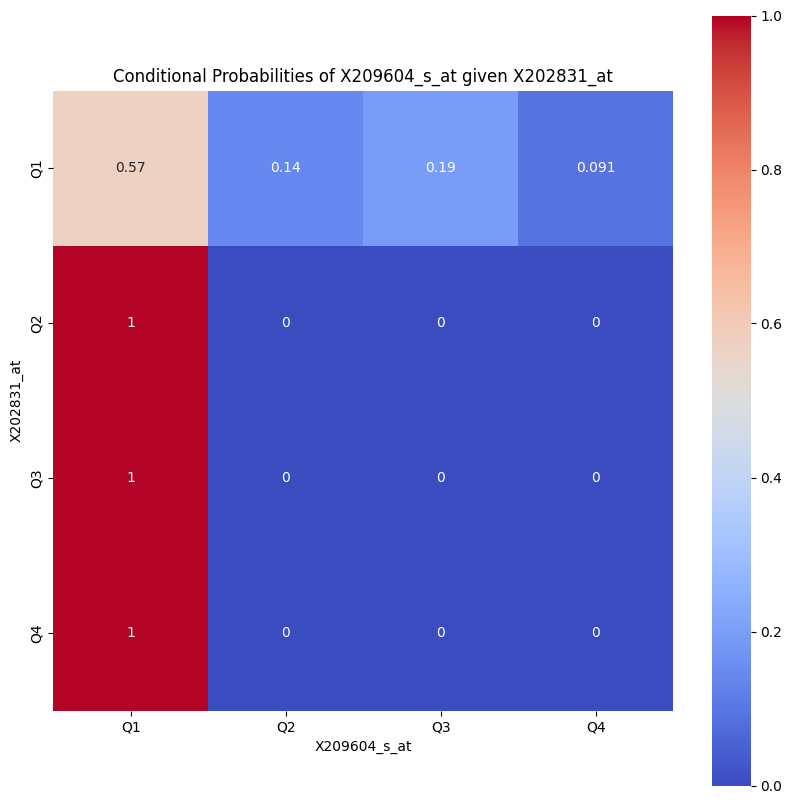

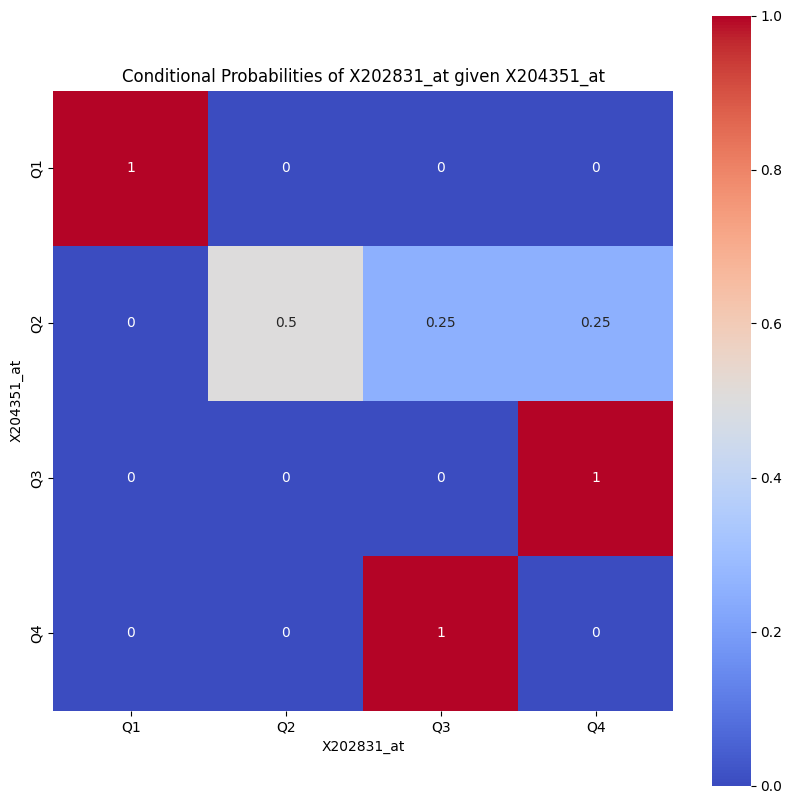

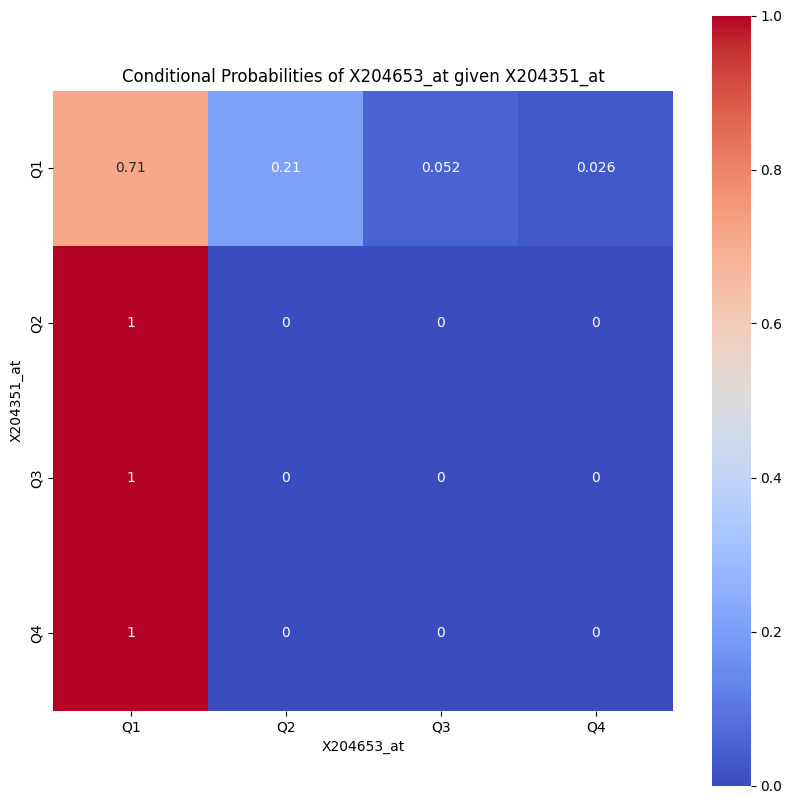

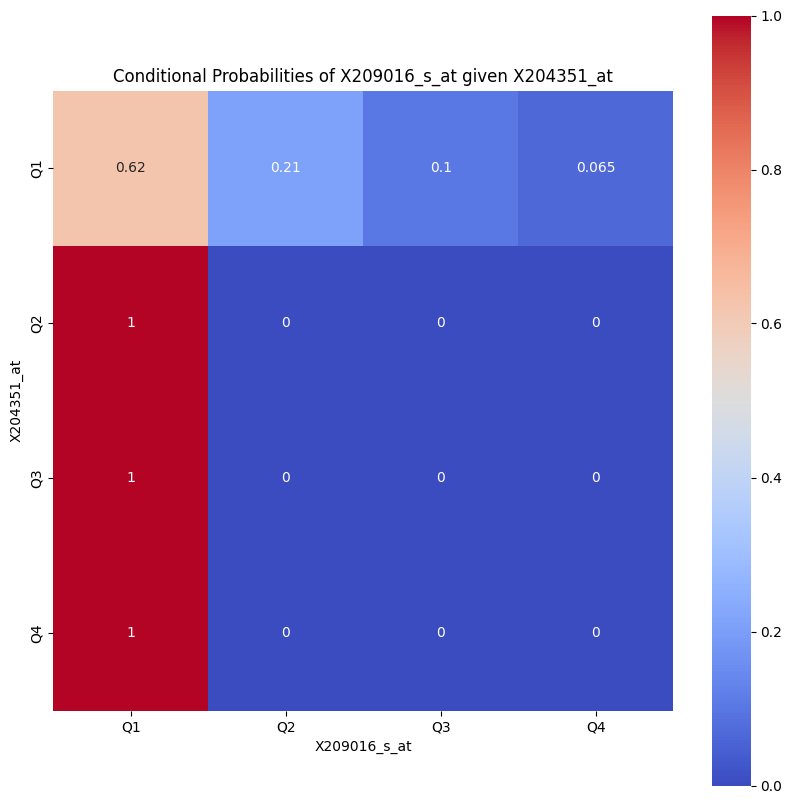

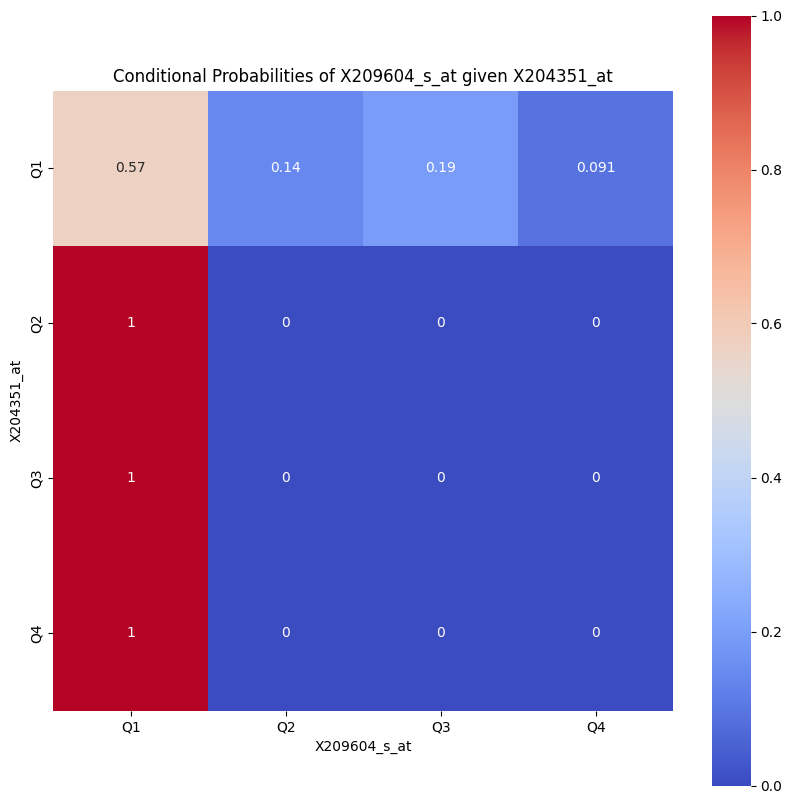

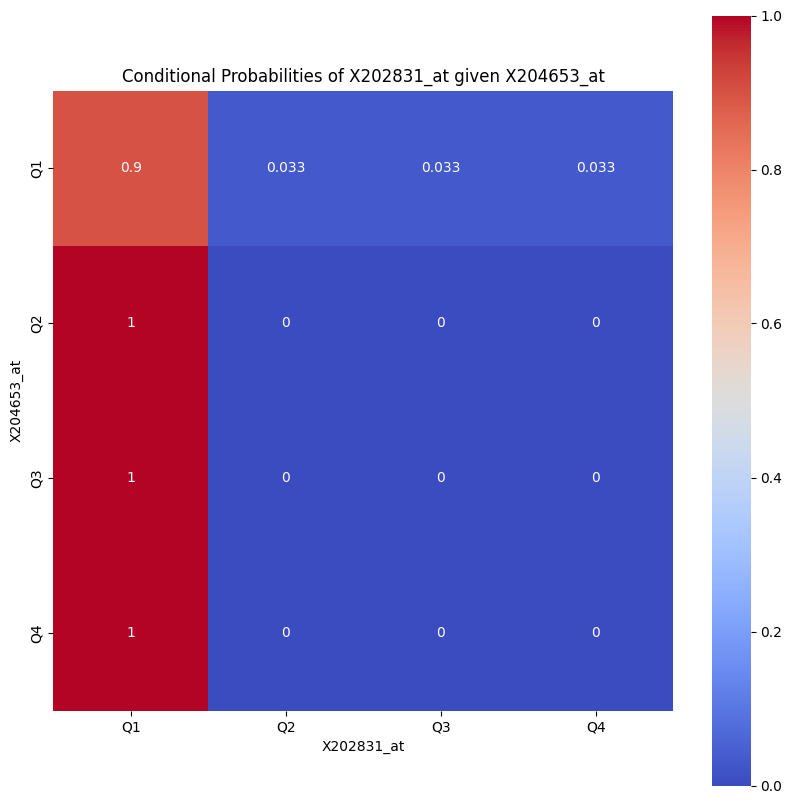

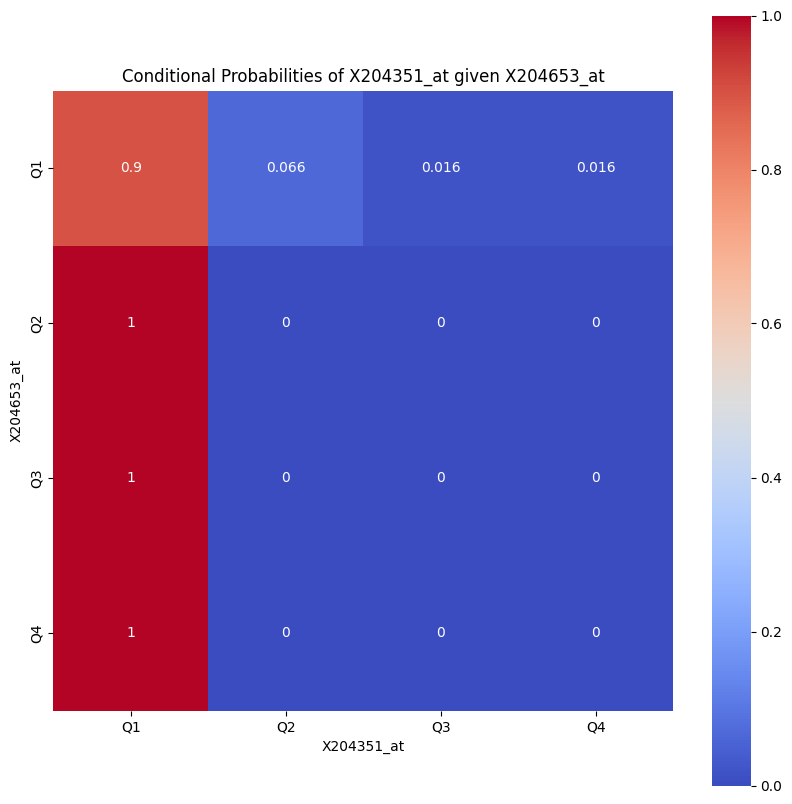

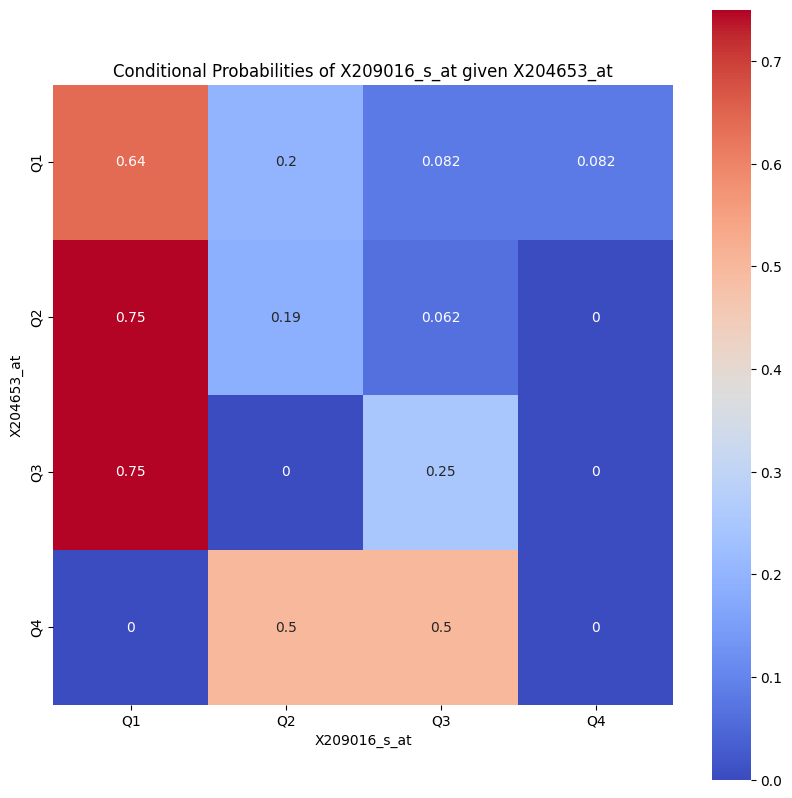

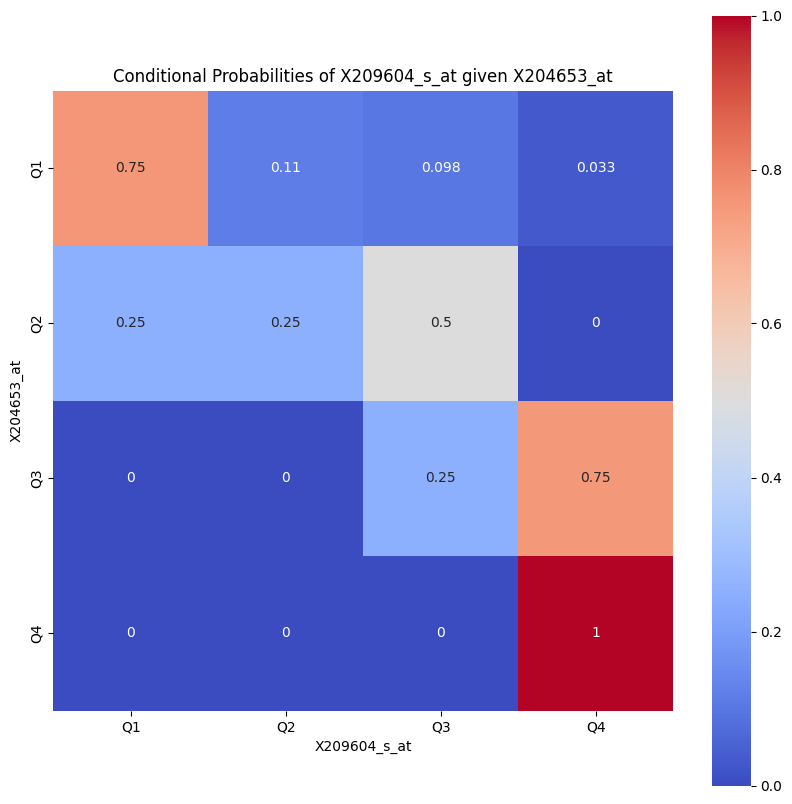

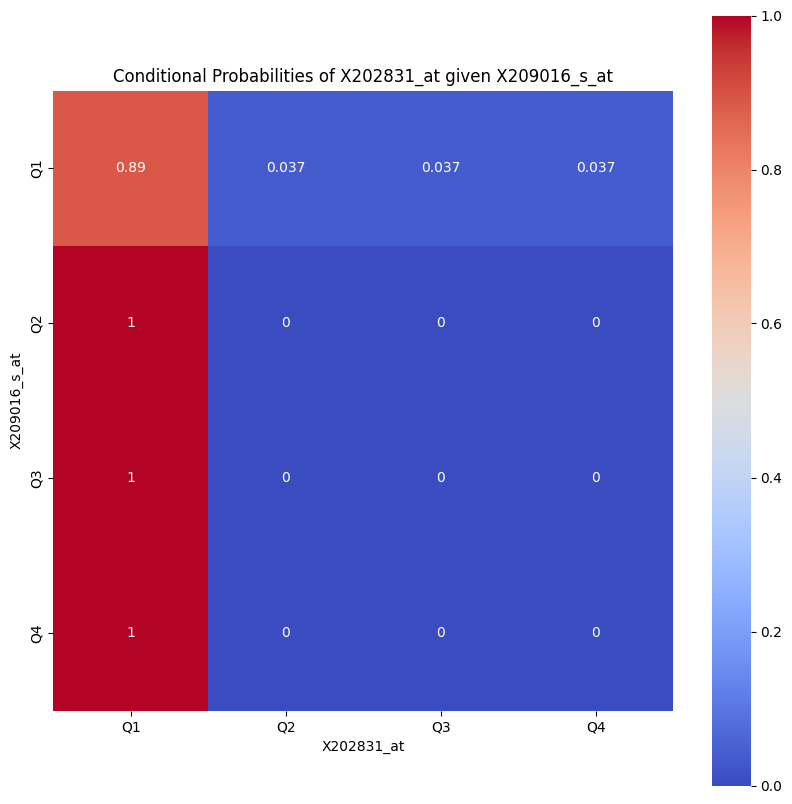

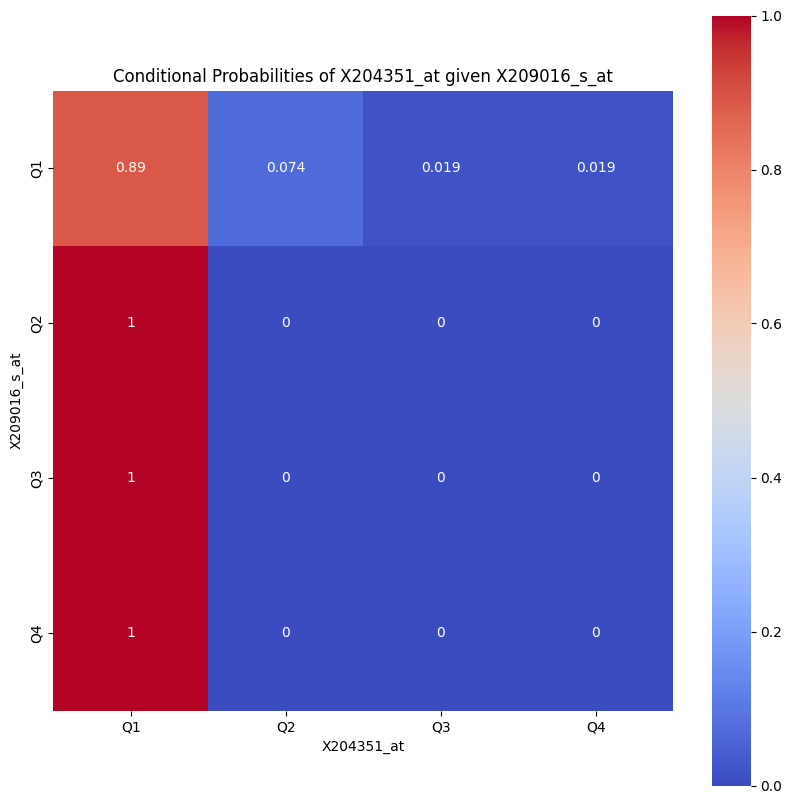

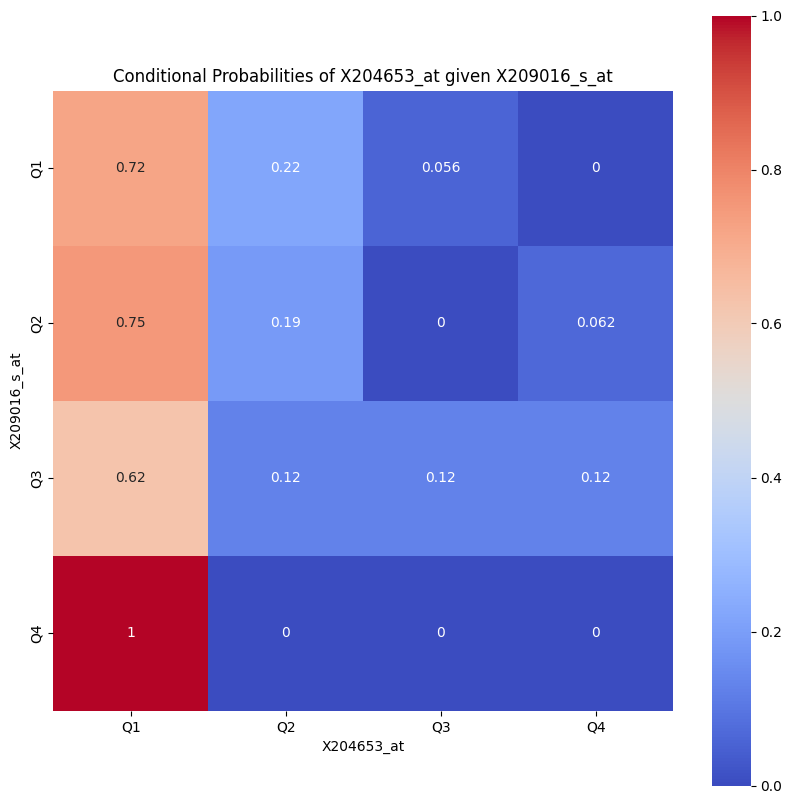

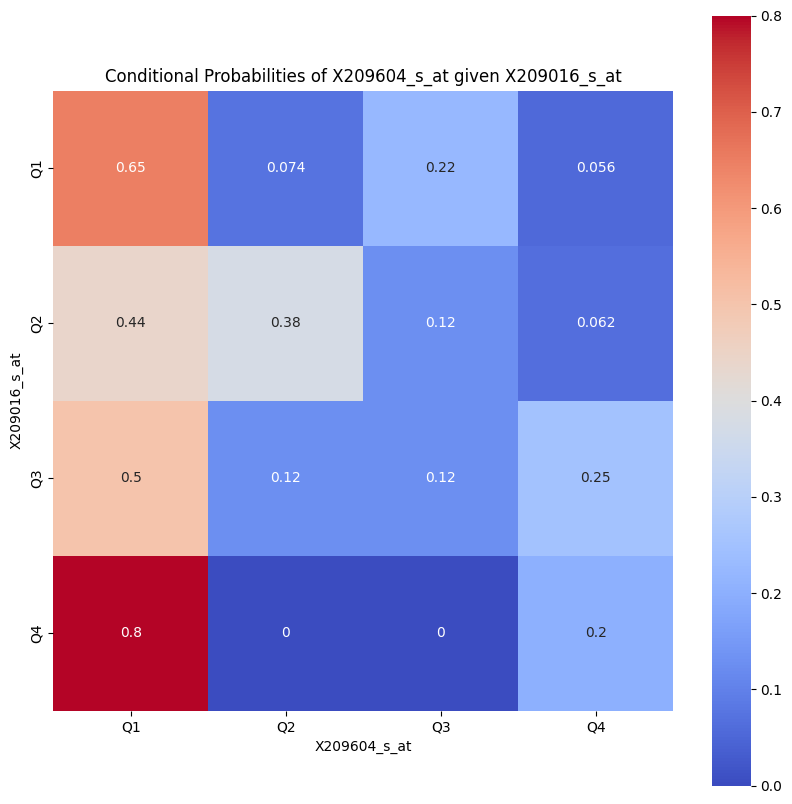

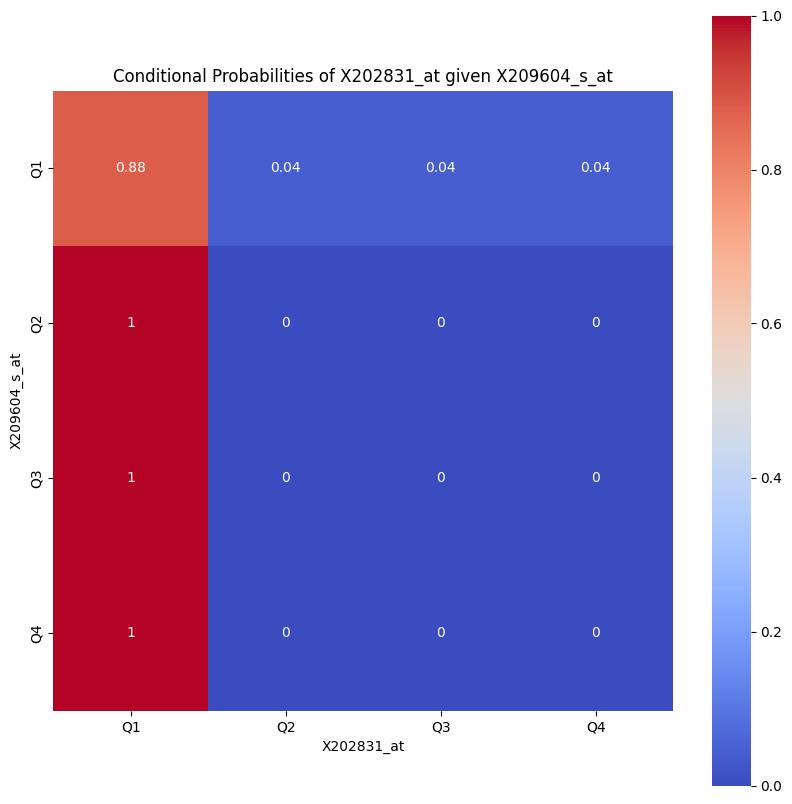

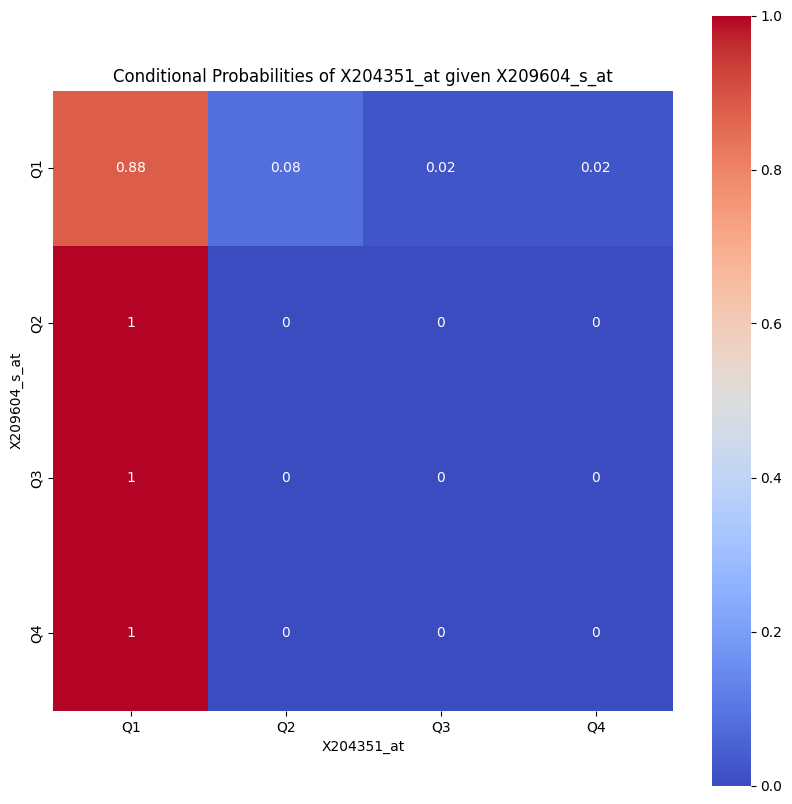

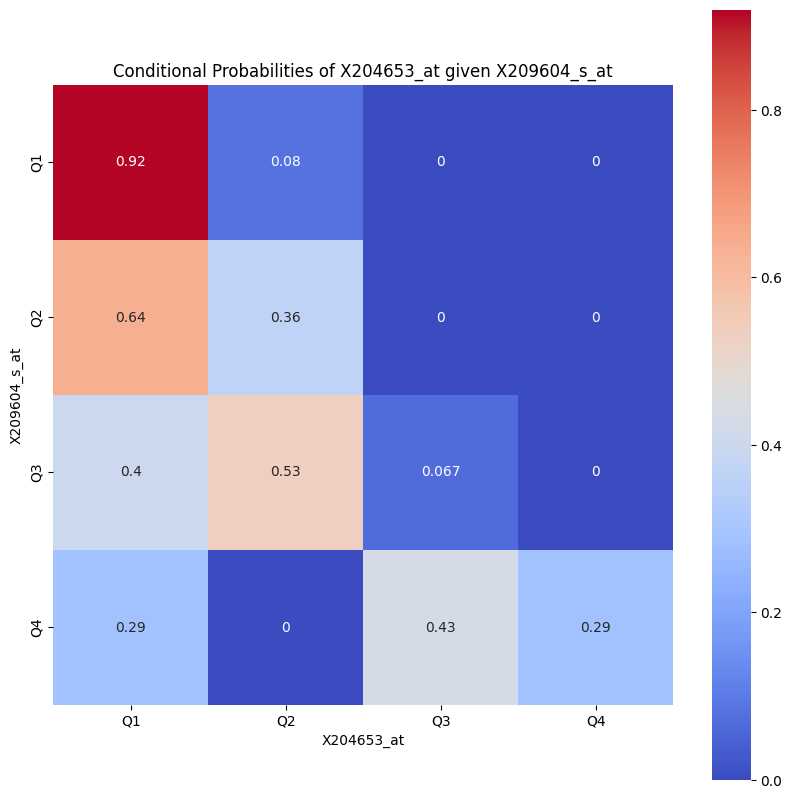

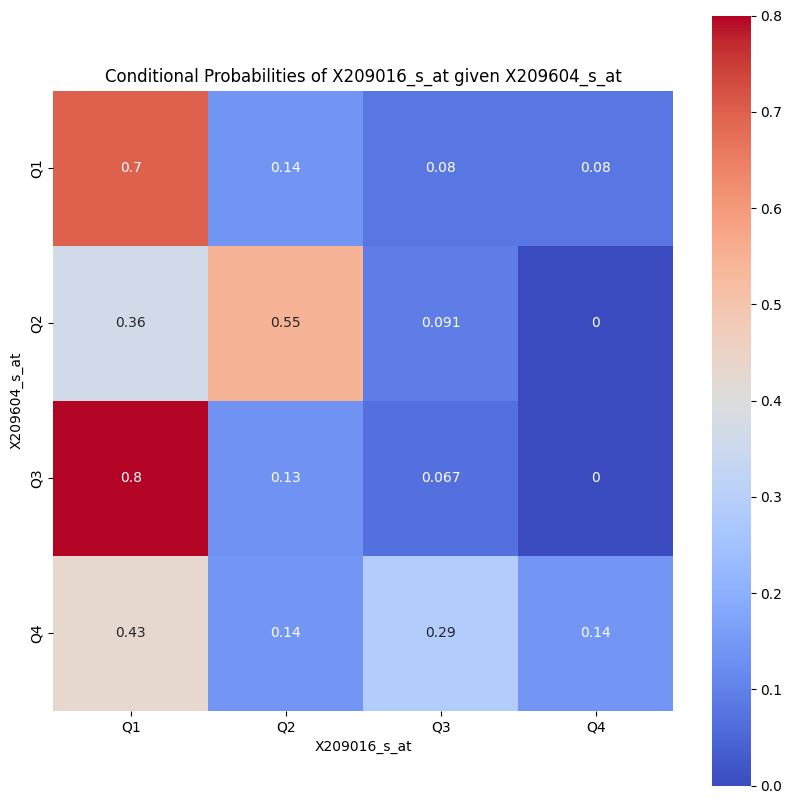

In [16]:
# visualizing conditional probabilities for each pair of features
def plot_conditional_prob(feature1, feature2):
    # Bin the continuous features into 4 equal-width bins
    X_train_binned = X_train_normalized_df.copy()
    X_train_binned[feature1] = pd.cut(X_train_normalized_df[feature1], 4, labels=["Q1", "Q2", "Q3", "Q4"])
    X_train_binned[feature2] = pd.cut(X_train_normalized_df[feature2], 4, labels=["Q1", "Q2", "Q3", "Q4"])
    
    contingency_table = pd.crosstab(X_train_binned[feature1], X_train_binned[feature2])
    prob_feature2_given_feature1 = contingency_table.div(contingency_table.sum(axis=1), axis=0)

    plt.figure(figsize=(10, 10))
    sns.heatmap(prob_feature2_given_feature1, annot=True, cmap='coolwarm', square=True)
    plt.title(f"Conditional Probabilities of {feature2} given {feature1}")
    plt.show()
    
# looping through all pairs of features and compute conditional probabilities
for i, feature1 in enumerate(selected_features):
    for j, feature2 in enumerate(selected_features):
        if i != j:
            plot_conditional_prob(feature1, feature2)

In [17]:
from scipy.stats import ttest_ind

# visualizing conditional probabilities for each pair of features
def t_test(feature1, feature2):
    # Perform an independent t-test between two groups
    group1 = X_train_normalized_df.reset_index(drop=True).loc[Y_train.reset_index(drop=True) == 'B', feature1]
    group2 = X_train_normalized_df.reset_index(drop=True).loc[Y_train.reset_index(drop=True) == 'C', feature2]
    t_stat, p_value = ttest_ind(group1, group2)

    # Print the t-statistic and p-value
    print(f"t-statistic between {feature1} and {feature2}:", t_stat)
    print(f"p-value between {feature1} and {feature2}:", p_value)
    print("-------------------------------------------")
    
# looping through all pairs of features and compute conditional probabilities
for i, feature1 in enumerate(selected_features):
    for j, feature2 in enumerate(selected_features):
        if i != j:
            t_test(feature1, feature2)

t-statistic between X202831_at and X204351_at: -5.152060160748416
p-value between X202831_at and X204351_at: 1.7777733560251866e-06
-------------------------------------------
t-statistic between X202831_at and X204653_at: 11.565367682749036
p-value between X202831_at and X204653_at: 7.866372823266387e-19
-------------------------------------------
t-statistic between X202831_at and X209016_s_at: 4.189207865497654
p-value between X202831_at and X209016_s_at: 7.082368732658777e-05
-------------------------------------------
t-statistic between X202831_at and X209604_s_at: 14.268836013242437
p-value between X202831_at and X209604_s_at: 8.206869965458824e-24
-------------------------------------------
t-statistic between X204351_at and X202831_at: -5.6205587555983225
p-value between X204351_at and X202831_at: 2.615724568483909e-07
-------------------------------------------
t-statistic between X204351_at and X204653_at: 10.515063176453511
p-value between X204351_at and X204653_at: 8.34923

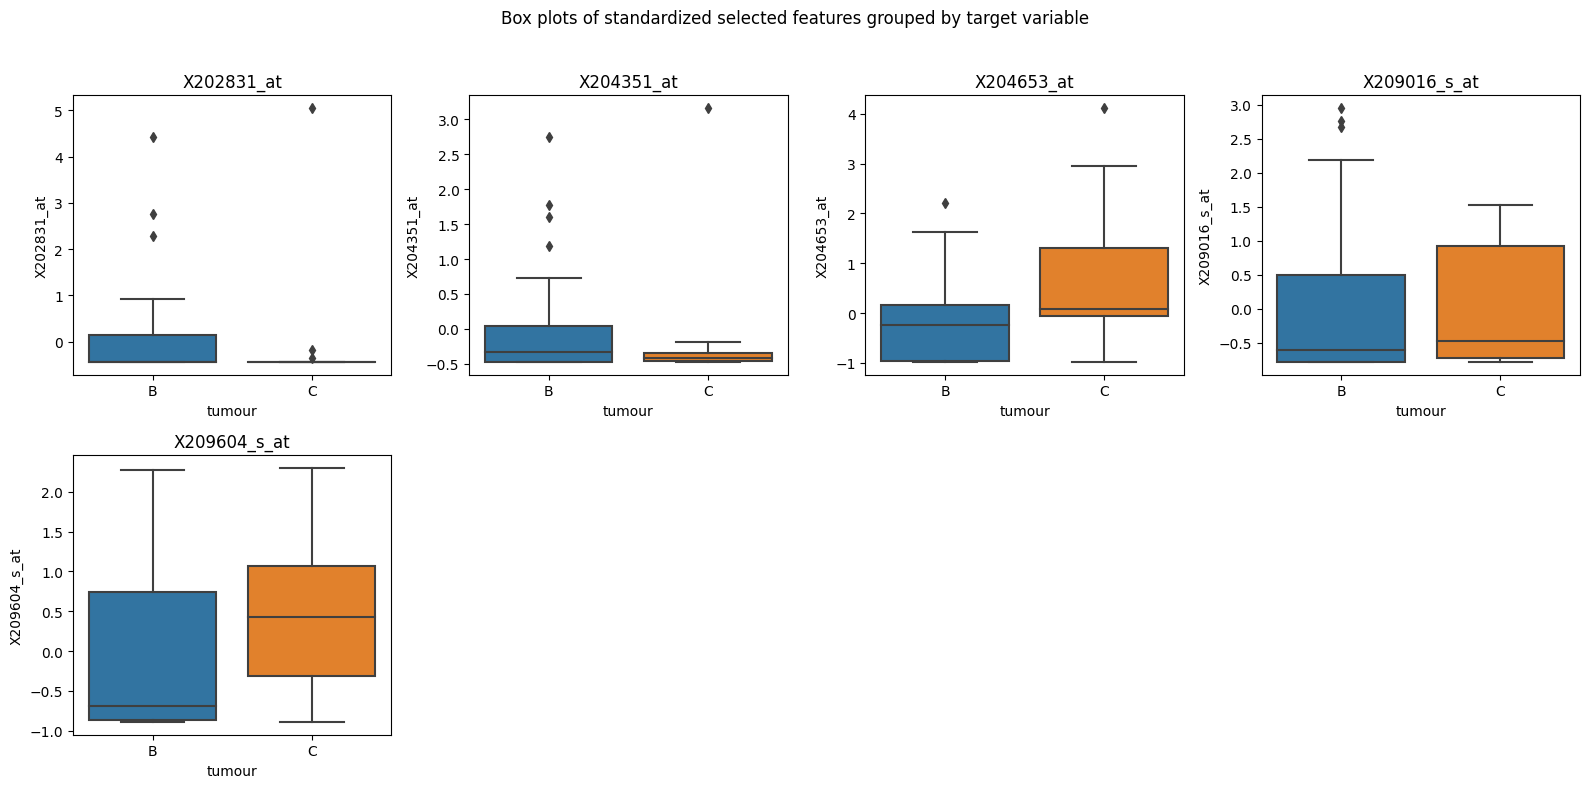

In [18]:
from sklearn.preprocessing import StandardScaler

# Joining the target variable back
scaled_selected_df = X_train_normalized_df.join(Y_train)

# Creating the subplots
n_rows = 2
n_cols = 4
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 8))

for i, feature in enumerate(selected_features):
    row, col = i // n_cols, i % n_cols
    sns.boxplot(x='tumour', y=feature, data=scaled_selected_df, ax=axes[row, col])
    axes[row, col].set_title(feature)

# Removing the unused subplots
for j in range(i + 1, n_rows * n_cols):
    fig.delaxes(axes[j // n_cols, j % n_cols])

plt.suptitle("Box plots of standardized selected features grouped by target variable")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


Cross-validation scores: [1.         1.         0.88235294 0.9375     1.        ]
Mean cross-validation score: 0.9639705882352942
              precision    recall  f1-score   support

           B       1.00      1.00      1.00        10
           C       1.00      1.00      1.00        11

    accuracy                           1.00        21
   macro avg       1.00      1.00      1.00        21
weighted avg       1.00      1.00      1.00        21

        feature  coefficient
0    X202831_at     1.044825
1    X204351_at     0.753814
2    X204653_at    -1.925854
3  X209016_s_at    -0.805873
4  X209604_s_at    -1.327156


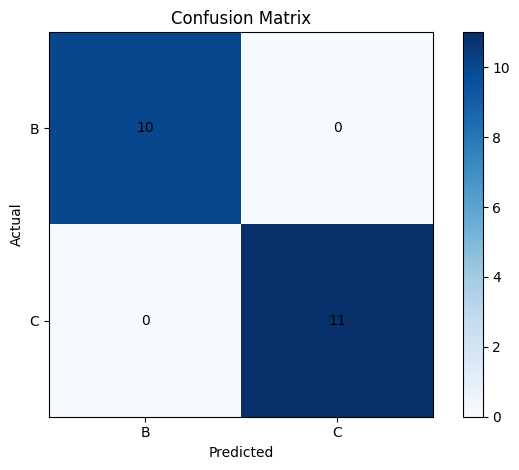

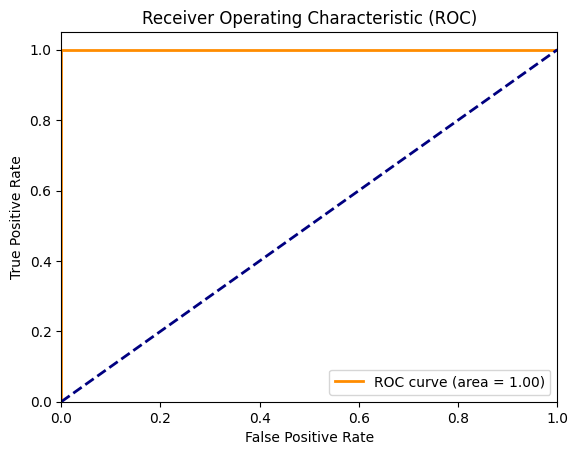

In [28]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.model_selection import cross_val_score

# selecting the features
X_train = X_train_normalized_df[selected_features]
X_test = X_test_normalized_df[selected_features]

# fitting the logistic regression model
lr = LogisticRegression(penalty = 'l2',max_iter=1000)
cv_scores = cross_val_score(lr, X_train, Y_train, cv=5)
print("Cross-validation scores:", cv_scores)
print("Mean cross-validation score:", cv_scores.mean())
lr.fit(X_train, Y_train)

# making predictions
Y_pred = lr.predict(X_test)
Y_pred_proba = lr.predict_proba(X_test)[:, 1]

# printing classification report
print(classification_report(Y_test, Y_pred))

# getting the coefficients for the selected features
coefficients = pd.DataFrame({'feature': list(selected_features), 'coefficient': lr.coef_[0]})
print(coefficients)


# printing confusion matrix
conf_mat = confusion_matrix(Y_test, Y_pred)
plt.imshow(conf_mat, cmap='Blues', interpolation='nearest')
plt.colorbar()
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
for i in range(len(conf_mat)):
    for j in range(len(conf_mat[0])):
        plt.text(j, i, str(conf_mat[i][j]), horizontalalignment='center', verticalalignment='center')
tick_marks = np.arange(len(np.unique(df['tumour'])))
plt.xticks(tick_marks, np.unique(df['tumour']))
plt.yticks(tick_marks, np.unique(df['tumour']))
plt.tight_layout()
plt.show()

# plotting ROC curve
fpr, tpr, _ = roc_curve(Y_test, Y_pred_proba, pos_label=df['tumour'].unique()[1])
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Calculate the log-likelihood
log_likelihood = rf.predict_log_proba(X_train_selected).sum()

# Calculate the number of parameters (k) and samples (n)
k = len(selected_features) + 1  # Add 1 for the intercept
n = X_train_selected.shape[0]

# Calculate AIC and BIC
aic = -2 * log_likelihood + 2 * k
bic = -2 * log_likelihood + k * np.log(n)

print("AIC: ", aic)
print("BIC: ", bic)

In [27]:
coefficients.to_csv('lr_coefficients.csv', index=False)

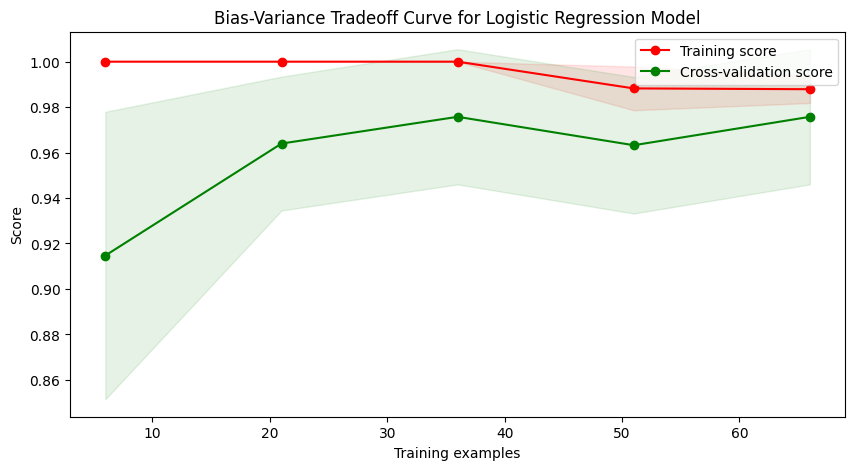

In [22]:
from sklearn.model_selection import learning_curve

# Defining function to plot bias-variance tradeoff
def plot_bias_variance_tradeoff(estimator, title):
    train_sizes, train_scores, test_scores = learning_curve(estimator, X_train_normalized_df, Y_train, train_sizes=np.linspace(0.1, 1.0, 5), cv=5)

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)

    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(10, 5))
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    plt.show()

# Plotting the bias-variance tradeoff curve for logistic regression model
plot_bias_variance_tradeoff(lr, "Bias-Variance Tradeoff Curve for Logistic Regression Model")
